In [1]:
########################################################################################
# Waleed. M Gondal, 2017                                                               #
# Gradient based Class Activation Maps implementation in TensorFlow                    #
# Weights from Caffe converted using https://github.com/ethereon/caffe-tensorflow      #
########################################################################################

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
from scipy.misc import imread, imresize
from imagenet_classes import class_names
from utils import normalize, draw_bbox
from grad_cam_model import Grad_CAM

In [2]:
# Assign weight file.
WEIGHT_PATH = 'vgg16_weights.npz'
N_LABELS = 1000
grad_cam = Grad_CAM(N_LABELS, WEIGHT_PATH)

# Define Placeholders for images and labels
images_tf = tf.placeholder( tf.float32, [None, 224, 224, 3], name="images")
labels_tf = tf.placeholder( tf.int32, [None], name='labels')

In [3]:
# Configure the model
output = grad_cam.network(images_tf, is_training=True, dropout=1.0)

# Read Test image
Read and resize the image

(-0.5, 223.5, 223.5, -0.5)

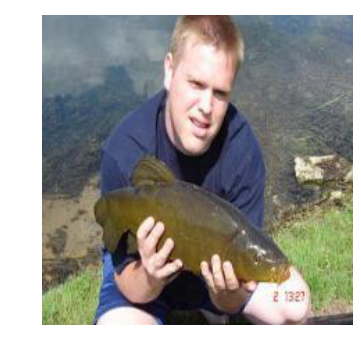

In [4]:
img = imread('1.JPEG', mode='RGB')
img = imresize(img, (224, 224))
plt.imshow (img)
plt.axis('off')

# Inference
Retrieve the last convolution layer's feature maps and the output scores

In [5]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
g = tf.get_default_graph()

# Define Gradient Backpropagation from output to last conv layer
last_conv_layer = g.get_tensor_by_name('conv5_3/conv5_3:0')
gradient = tf.gradients(tf.reduce_max(output, 1), last_conv_layer)
norm_grads = tf.div(gradient, tf.sqrt(tf.reduce_mean(tf.square(gradient))) + tf.constant(1e-5))

# Inference and gradients computation
output_val, grads_weights = sess.run([output, norm_grads], feed_dict={images_tf: np.expand_dims(img, axis = 0)})
grads_weights = np.squeeze(grads_weights)

# Sorting of output scores
pred = np.squeeze(output_val, axis=(0,))
pred = (np.argsort(pred)[::-1])[0:5]

# Assign Max Prediction
label_1 = pred[0]

# Gradient Class Activation Maps
Use the last convolution layer feature maps and the index of output node associated with the highest predictions 

(-0.5, 223.5, 223.5, -0.5)

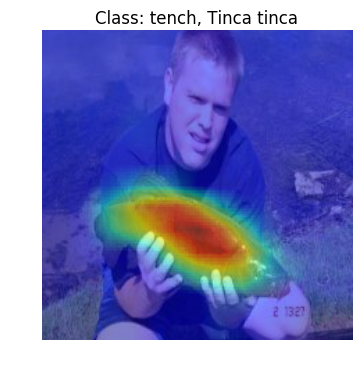

In [6]:
classmap = grad_cam.get_grad_cam(last_conv_layer, grads_weights)
class_map = sess.run([classmap], feed_dict={ images_tf: np.expand_dims(img, axis = 0)})
cmap_1 = np.squeeze(class_map)

# Plot Images and their respective Heatmaps
plt.imshow(img)
plt.imshow(normalize(cmap_1), cmap=plt.cm.jet, alpha=0.5, interpolation='nearest')
plt.title('Class: %s' %class_names[label_1])
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

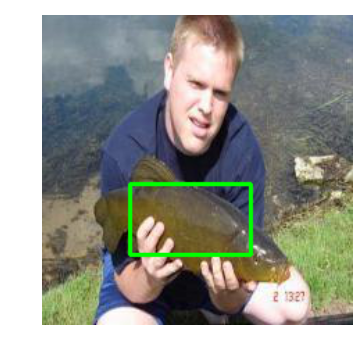

In [7]:
plt.imshow(draw_bbox(img, cmap_1, threshold = 0.6))
plt.axis('off')

# Guided Backpropagation Part of Graded CAM
Here the gradients are backpropagated all the way back to the input image.
Note: Guided backpropagation is different from simple backpropagation as it doesn't all the negative gradients flow back. This is acheived by thresholding the backward flow of negative gradients around non-linearities (ReLU) to zero.

The implementation of this threholding is done in the networks model file. For more details on Guided Backpropagation
consult  'Striving for Simplicity: The All Convolutional Net' Springenberg et al.

(-0.5, 223.5, 223.5, -0.5)

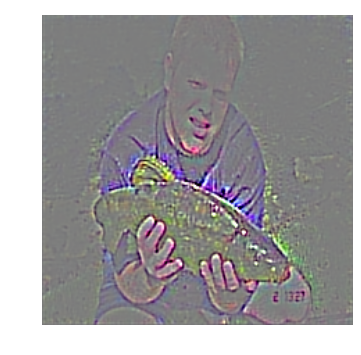

In [8]:
gradient_bp = tf.gradients(tf.reduce_max(output, 1), images_tf)
norm_grads = tf.div(gradient_bp, tf.sqrt(tf.reduce_mean(tf.square(gradient))) + tf.constant(1e-5))

# Gradients computation
grads_weights = sess.run([norm_grads], feed_dict={images_tf: np.expand_dims(img, axis = 0)})
grads_weights = np.squeeze(grads_weights)

grad_bp = normalize(grads_weights)

plt.imshow(grad_bp)
plt.axis('off')